# MVP 03 - Engenharia de Dados

## Objetivos do MVP

1. Este MVP tem como principal objetivo o desenvolvimento de um pipeline ETL (Extract, Transform and Load) robusto e escalável, implementando uma solução end-to-end (E2E) para integração de dados entre um servidor SFTP e um banco de dados PostgreSQL.

2. O pipeline será responsável pela extração automatizada de arquivos no formato .txt, que seguem uma estrutura padronizada e contêm informações cruciais relacionadas às transações financeiras processadas de uma das principais adquirentes de cartão do Supermercado analisado.

3. Por fim, esse pipeline é usado como uma das etapas do serviço de conciliação financeira que permitirá o controle das transações do Supermercado.

Escolha de tecnologias:

- Foi escolhido o uso do PostgreSQL e do armazenamento no Google Drive por motivos de custo, simplicidade e agilidade no desenvolvimento. Dado o tamanho reduzido do MVP e os custos associados a outras plataformas (AWS, GCP ou Databricks), optou-se por uma solução mais econômica e igualmente funcional, sem comprometer a qualidade técnica e os requisitos do projeto.

## Tryout - Exemplo de aplicação para fins de testes

### Importação de pacotes

In [3]:
!git clone https://github.com/edi414/mvp_03_postgratudation
!pip install dotenv


Cloning into 'mvp_03_postgratudation'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 89 (delta 30), reused 69 (delta 19), pack-reused 0 (from 0)
Receiving objects: 100% (89/89), 736.46 KiB | 8.46 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [4]:
import os
import pandas as pd
import psycopg2
from dotenv import load_dotenv
load_dotenv()
import sys
sys.path.append('/content/mvp_03_postgratudation')
from scripts.leitor_extratos import (
    process_file,
    prepare_dimension_tables
)
from scripts.reading_files import ExtratoTransacao
from scripts.transform_files import TransformerTrasacoes
from scripts.connection_db import (
    delete_file_data
)

connection_params = {
    'host': 'theatrically-rapt-filly.data-1.use1.tembo.io',
    'user': 'puc_rj_user_leitura',
    'password': 'puc_rj_leitura_password',
    'database': 'postgres',
    'port': '5432'
}

### Leitura dos dados brutos

In [14]:
teste_file = 'EXTRATO_UNICA_51309_20240917_00003'
file_path = r'/content/mvp_03_postgratudation/data/EXTRATO_UNICA_51309_20240917_00003'
extrato = ExtratoTransacao(file_path=file_path)
df_header, df_transacoes, df_trailer = extrato.process_file()

print("\nPrimeiras transações:")
display(df_transacoes.head())


Primeiras transações:


,codigo_registro,identificacao_loja,nsu_host_transacao,data_transacao,horario_transacao,tipo_lancamento,data_lancamento,tipo_produto,meio_captura,valor_bruto_venda,...,data_vencimento_original,indicador_deb_balance,indicador_reenvio,nsu_origem,reservado_final,numero_operacao_recebivel,sequencial_operacao_recebivel,tipo_operacao_recebivel,valor_operacao_recebivel,nseq
0,CV,008935303000108,000190825603,20240916,000000,0,20241017,C,3,34.00,...,20241017,,,000031,,,00,,0.00,000003
1,CV,008935303000108,000190839036,20240916,000000,0,20241017,C,3,73.29,...,20241017,,,000032,,,00,,0.00,000004
2,CV,008935303000108,000190850566,20240916,000000,0,20241017,C,3,38.54,...,20241017,,,160042,,,00,,0.00,000005
3,CV,008935303000108,000190853893,20240916,000000,0,20241017,C,3,25.98,...,20241017,,,160043,,,00,,0.00,000006
4,CV,008935303000108,000190970775,20240916,000000,0,20241017,C,3,10.00,...,20241017,,,160063,,,00,,0.00,000007


Nessa etapa, é feita a leitura do arquivo exemplo de extrato de transações.

1. O arquivo é processado pela classe `ExtratoTransacao` que:
    - Lê o arquivo e separa em 3 partes: `header`, `transações` e `trailer`
    - O `header` contém informações gerais do arquivo como data de geração
    - As `transações` são o corpo do arquivo com os dados das vendas
    - O `trailer` contém totalizadores do arquivo

2. O resultado são 3 dataframes:
- `df_header`: com dados do cabeçalho
- `df_transacoes`: com todas as transações do arquivo
- `df_trailer`: com os totalizadores

### Transformação e Validação

In [6]:
df_transacoes['file_name'] = 'EXTRATO_UNICA_51309_20240917_00003'

transformer = TransformerTrasacoes(dataframe=df_transacoes)
df_transacoes_validated = transformer.validate_all()

if isinstance(df_transacoes_validated, list):
    print("\nErros encontrados:")
    for erro in df_transacoes_validated:
        print(f"- {erro}")
else:
    print("\nValidação concluída com sucesso!")
    print(f"Total de registros validados: {len(df_transacoes_validated)}")

Todas as validações passaram.

Validação concluída com sucesso!
Total de registros validados: 191


1. O método validate_all() é chamado para validar todos os dados do dataframe
2. Há uma verificação condicional do resultado:
    - Se o resultado for uma lista, significa que foram encontrados erros na validação
    - Se não for lista, significa que a validação foi bem sucedida
3. Em resumo, este trecho realiza a transformação e validação dos dados das transações antes de prosseguir com o processamento e inserção

### Inserção no banco

> disclaimer: para fins de testes será feito um processo com um schema em ambiente de desenvolvimento, com o mesmo arquivo sendo feito a deleção do banco e depois a inserção para teste do pipeline.

#### Preparando as dimensões

In [7]:
df_tempo, df_loja, df_produto, df_pagamento = prepare_dimension_tables(df_transacoes_validated)

print("Dimensões preparadas:")
print(f"Tempo: {len(df_tempo)} registros únicos")
print(f"Loja: {len(df_loja)} registros únicos")
print(f"Produto: {len(df_produto)} registros únicos")
print(f"Pagamento: {len(df_pagamento)} registros únicos")

Dimensões preparadas:
Tempo: 6 registros únicos
Loja: 1 registros únicos
Produto: 6 registros únicos
Pagamento: 3 registros únicos


A função `prepare_dimension_tables` é responsável por criar as tabelas dimensionais
a partir do dataframe de transações validado. Ela separa os dados em 4 dimensões:

1. Tempo: Agrupa informações temporais (data, mês, ano etc)
2. Loja: Dados do estabelecimento comercial  
3. Produto: Informações sobre os produtos/bandeiras
4. Pagamento: Detalhes das formas de pagamento

Esta separação em dimensões caracteriza um esquema estrela, que é importante pois:
1. Centraliza os fatos (transações) conectados às dimensões, facilitando análises
2. Simplifica consultas complexas através de junções diretas com as dimensões
3. Otimiza o desempenho do data warehouse ao reduzir redundâncias
4. Permite escalar o volume de dados mantendo a consistência e facilita a manutenção
5. Possibilita análises multidimensionais (OLAP) de forma eficiente

No contexto do tryout, essas dimensões serão usadas para:
1. Inserção organizada no banco de dados
2. Análises específicas por produto/bandeira e simulações de MDR


#### Deletando file tryout

In [18]:
print("\n1. Deletando dados existentes...")
if delete_file_data(**connection_params, file_name=teste_file):
    print("✓ Dados deletados com sucesso")
else:
    print("✗ Erro ao deletar dados")


1. Deletando dados existentes...
✓ Dados deletados com sucesso


Para esse teste é importante realizar a limpeza dos dados existentes no banco de dados, especificamente desse arquivo teste,
pois o objetivo do tryout é simular o pipeline ETL que será executado periodicamente.

Ao deletar os dados anteriores, garantimos que:

1. Podemos validar todo o fluxo de processamento desde o início
2. Evitamos erros de inserção de valores duplicados

#### Inserindo file tryout

In [19]:
test_file = 'EXTRATO_UNICA_51309_20240917_00003'
process_file(file_name=test_file,
             local_file_path=file_path,
             google_drive_path='teste',
             connection_params=connection_params,
             is_tryout=True
             )

Todas as validações passaram.


True

A função `process_file` executa o pipeline ETL completo:
1. Extrai os dados do arquivo de extrato bancário local ou do Google Drive
2. Transforma os dados aplicando validações e padronizações necessárias
3. Carrega os dados transformados no banco de dados PostgreSQL

Com os dados inseridos no banco, podemos prosseguir para a próxima seção onde
realizaremos análises para responder perguntas de negócio relacionadas à taxas MDR e simulações.

## Análises e problemas de negócio

**Problemas de negócio**

1. Otimização de Custos: Qual o impacto financeiro de alterar as taxas MDR por produto?
2. Análise de Desempenho: Quais produtos têm as taxas MDR mais altas?
5. Monitoramento: Como acompanhar a evolução das taxas MDR por produto ao longo do tempo?

In [20]:
from scripts.analysis import (
    calculate_mdr_by_produto,
    plot_mdr_by_produto,
    simulate_mdr_by_product
)

**Funções de Análise MDR**

**1. `calculate_mdr_by_produto`**
- Calcula o MDR atual por produto, considerando cada NSU como uma transação única
- Agrupa dados por produto, mostrando volume total, valor líquido e MDR percentual  
- Permite filtrar por mês específico para análises pontuais

**2. `plot_mdr_by_produto`**
- Visualiza os resultados do cálculo de MDR por produto
- Apresenta gráficos de barras para MDR percentual e volume nominal
- Facilita a identificação visual de produtos com taxas mais altas

**3. `simulate_mdr_by_product`**  
- Simula o impacto de novas taxas MDR por produto e tipo de parcelamento
- Compara MDR atual vs. proposto ao longo do tempo
- Calcula o impacto total das mudanças propostas

/content/mvp_03_postgratudation/scripts/analysis.py:84: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, params=params)


,codigo_produto,descricao,total_transacoes,valor_total,valor_liquido,mdr_percentual,mdr_nominal
0,Master Crédito,Master Crédito,7017,537058.11,526859.31,1.899012,10198.80
1,Visa Crédito,Visa Crédito,3595,307719.96,301855.18,1.905882,5864.78
2,Master Débito,Master Débito,2751,92935.10,92171.05,0.822133,764.05
3,Visa Débito,Visa Débito,1961,90137.87,89402.86,0.815429,735.01
4,Elo Crédito,Elo Crédito,371,31361.11,30740.88,1.977704,620.23
5,Elo Débito,Elo Débito,1150,65180.47,64626.37,0.850101,554.10
6,Outros,Outros,1509,41345.41,40987.47,0.865731,357.94


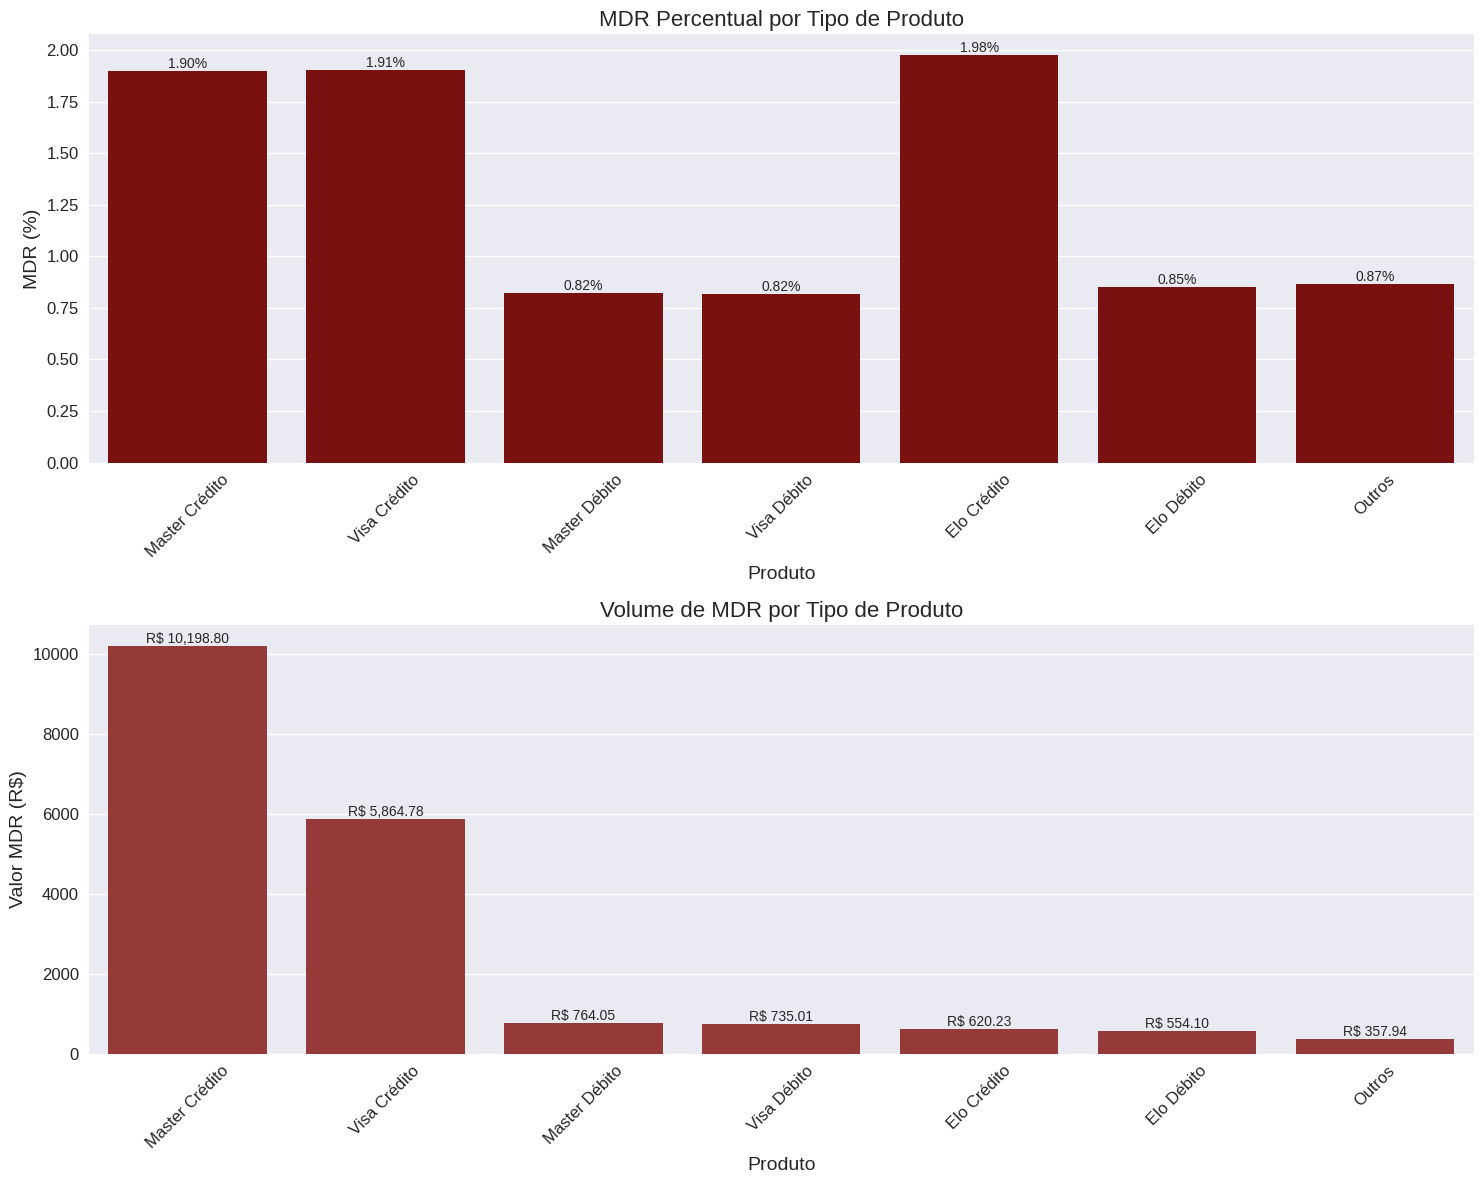

In [21]:
mdr_produto = calculate_mdr_by_produto(connection_params)
display(mdr_produto)
plot_mdr_by_produto(mdr_produto)

Em termos absolutos:

1. **Otimização de Custos**, as modalidades com maior impacto financeiro são:
    - Master Crédito: R$ 10.198,80 (56,6% do MDR total)
    - Visa Crédito: R$ 5.864,78 (32,6% do MDR total)

* Portanto, em termos de otimização e negociação das taxas, o foco deve ser nas operações de crédito, que representam 89,2% do custo total de MDR.

Em termos relativos:

2. **Análise de Taxas MDR**, as taxas de MDR com percentual mais elevado são:
    - Elo Crédito: 1,98%
    - Master Crédito: 1,90%
    - Visa Crédito: 1,91%

* Desta forma, o foco de otimização deve ser nas operações de crédito, dado que as taxas de débito já possuem taxas mais competitivas.

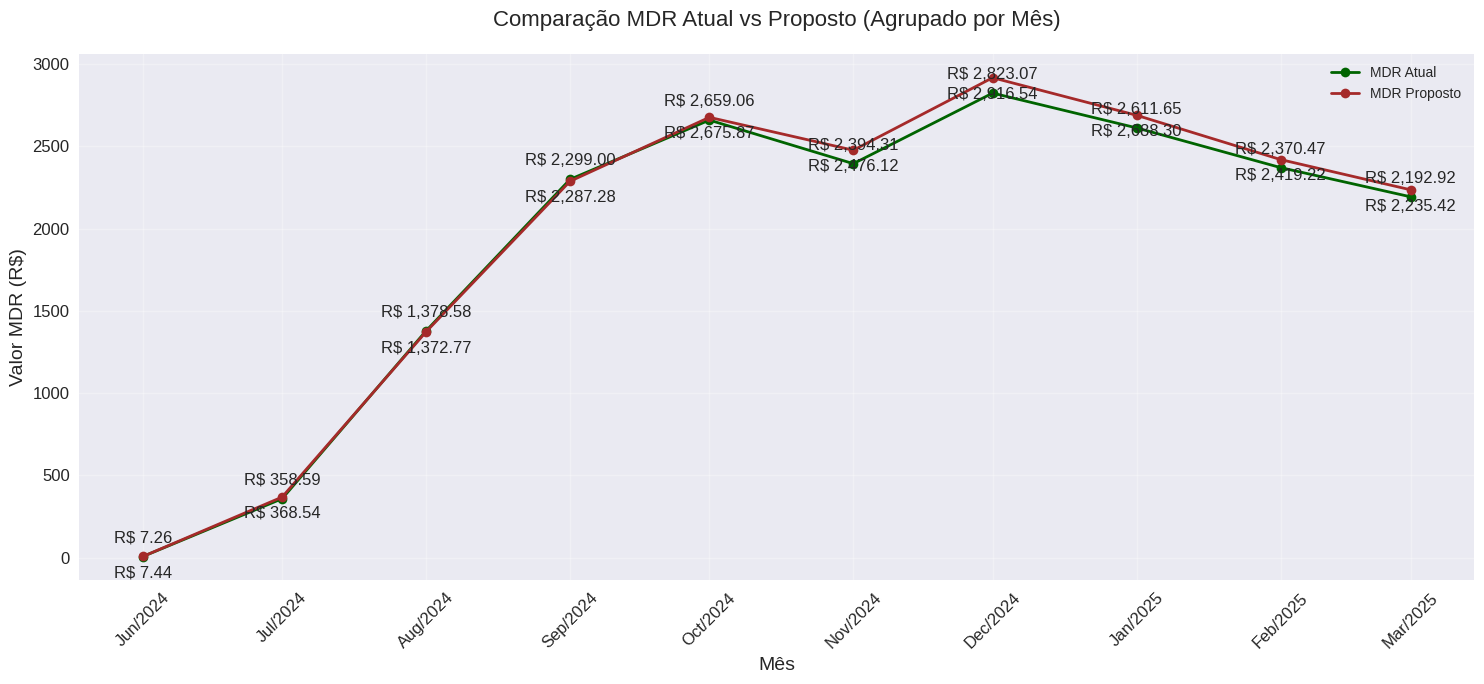

,mes,codigo_produto,tipo_parcelamento,total_transacoes,volume_total,mdr_atual,mdr_proposto,diferenca_mdr
0,2024-06-01,Visa Crédito,parcelado,1,210.00,4.20,4.3050,0.1050
1,2024-06-01,Master Crédito,parcelado,1,152.94,3.06,3.13527,0.07527
2,2024-07-01,Master Crédito,parcelado,55,10028.39,200.59,205.581995,4.991995
3,2024-07-01,Visa Crédito,parcelado,32,7599.51,151.97,155.789955,3.819955
4,2024-07-01,Elo Crédito,parcelado,2,264.40,6.03,7.16524,1.13524
...,...,...,...,...,...,...,...,...
76,2025-03-01,Elo Crédito,parcelado,4,258.19,5.17,6.996949,1.826949
77,2025-03-01,Visa Débito,a_vista,259,12472.91,99.80,118.492645,18.692645
78,2025-03-01,Elo Crédito,a_vista,41,3609.67,65.67,73.637268,7.967268
79,2025-03-01,Outros,a_vista,425,10210.55,82.94,82.94,0.00


In [22]:
taxas = {
    "Visa Débito": {
        "a_vista": {
            "mdr_percentual": 0.95
        }
    },
    "Master Débito": {
        "a_vista": {
            "mdr_percentual": 0.95
        }
    },
    "Visa Crédito": {
        "a_vista": {
            "mdr_percentual": 1.74
        },
        "parcelado": {
            "mdr_percentual": 2.05
        }
    },
    "Master Crédito": {
        "a_vista": {
            "mdr_percentual": 1.74
        },
        "parcelado": {
            "mdr_percentual": 2.05
        }
    },
    "Elo Débito": {
        "a_vista": {
            "mdr_percentual": 1.30
        }
    },
    "Elo Crédito": {
        "a_vista": {
            "mdr_percentual": 2.04
        },
        "parcelado": {
            "mdr_percentual": 2.71
        }
    }
}

simulacao, impacto_total = simulate_mdr_by_product(
    connection_params=connection_params,
    taxas_json=taxas
)

display(simulacao)

**Novas taxas propostas**

1. Débito
    *  Visa/Master: 0,95%
    *  Elo: 1,30%

2. Crédito à vista
    *  Visa/Master: 1,74%
    *  Elo: 2,04%

3. Crédito parcelado
    *  Visa/Master: 2,05%
    *  Elo: 2,71%

**Impactos no negócio**

1. Tendência de aumento nos custos MDR:
    - Diferença média mensal: aproximadamente R$ 42,50 de aumento
    - Maior impacto em dezembro/2024: diferença de R$ 93,47 (R$ 2.823,07 versus R$ 2.816,54)
    - Há uma sazonalidade no mês de dezembro relacionada ao aumento de vendas e transações no varejo neste período.
2. A nova estrutura de taxas resultará em um aumento moderado nos custos de MDR:
    - Os produtos Visa apresentam maior sensibilidade às mudanças
    - O maior impacto ocorre nas transações de débito à vista

* Diante desse cenário, faz-se necessária uma renegociação e/ou apresentação de um plano que traga outros benefícios para o Supermercado.

## Próximos passos

1. **Evoluções Tecnológicas**

    * Automatização do Pipeline de Dados
        - Criar rotinas de validação e limpeza dos dados
        - Desenvolver sistema de monitoramento da qualidade dos dados

    * Infraestrutura
        - Migrar solução para ambiente cloud, principalmente a gestão de arquivos para AWS S3 ou GCP
        - Criar APIs para consumo dos resultados

2. **Aplicações no Negócio**

    * **Otimização Comercial**
        - Criar dashboard para área comercial com ferramentas que apoiem a negociação com adquirentes

    * **Conciliação Financeira**
        - Desenvolver relatórios automatizados de conciliação entre vendas e recebimentos
        - Implementar alertas para divergências entre valores esperados e recebidos
        - Criar dashboard para acompanhamento do aging de recebíveis